# San Francisco Crime Classification

##### Authors:
- Dhrupa Patel (015265887)
- Dhruvi Shah (015570373)
- Kinjal Dhanani (015932462)

### Introduction

- Objective:
Our main objective was to predict the crime category in San Francisco using the open-source San Francisco Crime dataset.

- Approach:
In order to predict the crime category, we experimented with different classification and clustering algorithms like K-Nearest Neighbors, Decision Tree Classification, Random Forest Classification, K-Means and tried different features of the dataset and also derived new features with the help of existing ones to find which were more relevant or had more impact on the crime category.

In [92]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scipy.stats as st
from sklearn import preprocessing
import plotly
from sklearn.preprocessing import StandardScaler  
from sklearn.tree import DecisionTreeClassifier
# import plotly.plotly as py
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
import pygeohash as gh
from chart_studio import plotly
# import plotly.plotly as py
import plotly.graph_objs as go
import time
import pickle
import matplotlib
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_curve, auc,confusion_matrix
from sklearn import metrics

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline

## Data Exploration and preprocessing

The dataset used for this project was San Francisco Crime Classification that was available on Kaggle for an online competition. The dataset contains the following features:
- Longitude – X coordinates on the map where the crime occurred.
- Latitude – Y coordinates on the map where the crime occurred.
- Address – The address of the crime incident.
- Day of Week – The day of the week (i.e. Thursday)
- Date – The date of the crime in the following format:YYYY-mm-dd hh:MM:ss. 

Thus, you can deduce the following: Year, Month, Day, Hour, Minute, Second.
- District – Police district to which the crime is assigned.
- Resolution – The resolution taken to address the crime.
- Category – The type of the crime. This is the target/label that we need to predict.

The dataset consisted of 800,000 observations with 9 features. The Date column was further split into a date, time, a day for further use.

In [93]:
train=pd.read_csv("train.csv");
test=pd.read_csv("test.csv");
train['Dates']=pd.to_datetime(train['Dates'])
test['Dates']=pd.to_datetime(test['Dates'])
output_class_labels=train['Category'].unique()
print("Total Training data:",train.shape[0])
print("Total features:",train.shape[1])
train.head()

Total Training data: 878049
Total features: 9


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


##### Check if the data contains any missing values to handle it

In [94]:
train.apply(lambda x: sum(x.isnull()),axis=0)

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

### It can be induced that the dataset does not contain any missing values, hence no imputation is required
### Now we'll perform visualization on the dataset to understand pattern from the dataset.

<Figure size 2160x2160 with 0 Axes>

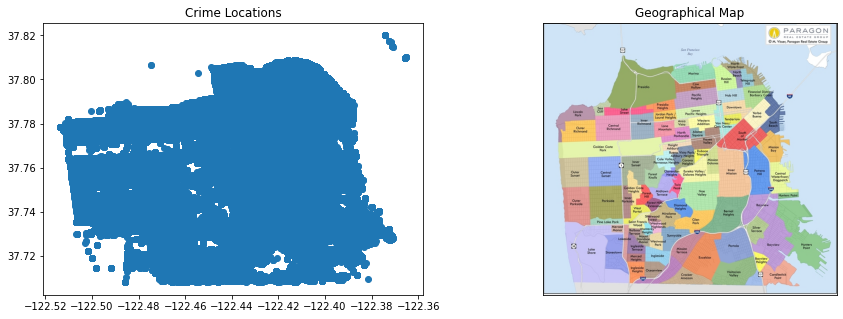

In [95]:
plt.figure(figsize=(30,30))
# longitudes vs latitudes
longitudes=train['X']
latitudes=train['Y']
subset=500000
latitudes=latitudes[0:subset]
longitudes=longitudes[0:subset]
plt.figure(figsize=(15,5))
axis_label_font = {'size':'20', 'color':'#165880'}
axis_tic_font = {'size':'20', 'color':'#165880'}

plt.xlabel("Latitude",axis_label_font)
plt.ylabel("Longitude",axis_tic_font)


plt.xticks(np.arange(-122.4, -122.6))
plt.yticks(np.arange(37.46, 37.85))

plt.subplot(1,2,1)
plt.scatter(longitudes, latitudes)
plt.title("Crime Locations")
plt.subplot(1,2,2)
sf=plt.imread('sanfr.jpg')
plt.xticks([])
plt.yticks([])
plt.imshow(sf)
plt.title("Geographical Map")
plt.show()

##### Transformations:
It makes more sense to break the time stamp in day, month, year, hour, miniute and seconds and utilize the date, month and hour as the feature instead of the time stamp. In addition we will drop the timestamp column and also drop the resolution column as discussed earlier and Descript column

In [96]:
train['Date']=train.iloc[:,0].apply(lambda x: x.day)
train['Month']=train.iloc[:,0].apply(lambda x: x.month)
train['Hour']=train.iloc[:,0].apply(lambda x: x.hour)
train.drop('Dates', axis=1, inplace=True)
train.drop('Descript', axis=1, inplace=True)

As suggested by the Abouelnaga, 2016[1] Most of the Address variables could be usesful by checking if it contains the Keyword "BLOCK". SO lets create a feature Block_Ind which represents whether an addresss contains BLOCK word. In addition we will extract the Street number from the address if present else will put as 0.

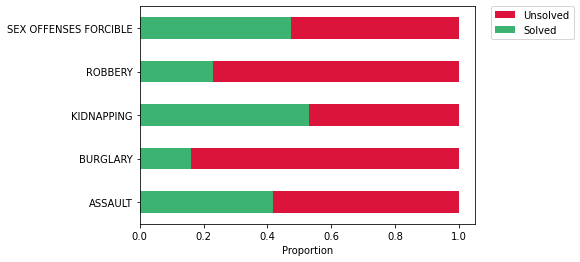

In [97]:
# Pick crime types of interest
violent = train[train.Category.isin(['ASSAULT', 'BURGLARY',
                                       'KIDNAPPING', 'ROBBERY',  
                                       'SEX OFFENSES FORCIBLE'])].copy()
violent
#Create Arrest variable
violent['Arrest'] = np.where(violent['Resolution'].isin(['NONE', 'NOT PROSECUTED']), 0,1)

# Calculate counts
arrest_counts = violent['Category'][violent.Arrest==1].value_counts()[0:9]
total_counts = violent['Category'].value_counts()[0:9]
arrest_counts = arrest_counts/(total_counts).sort_index()
total_counts = total_counts/(total_counts).sort_index()

# Plot values
total_counts.plot.barh(color='crimson', label= 'Unsolved')
arrest_counts.plot.barh(color='mediumseagreen', label='Solved')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Proportion')
plt.show()

In [98]:
train['Block_Ind']=train['Address'].apply(lambda x: 1 if 'block' in x.lower() else 0)
train['Street'] = train['Address'].apply(lambda x: x.split(" ")[0] if x.split(" ")[0].isnumeric() else 0)
train.drop('Address', axis=1, inplace=True)

In [99]:
train = train.assign(Day_Sessions=pd.cut(train['Hour'],[-1,6,12,18,25],labels=['Morning','Afternoon','Night','Mid-Night']))

### Normalization

We are going to normalize the latitude and longitude

In [100]:
min_X = train['X'].min()
min_Y = train['Y'].min()
train['X'] = (train['X'] - min_X)
train['Y'] = (train['Y'] - min_Y)

### Crime data based on Day of the Week, Date, Month and Day Session of the Day

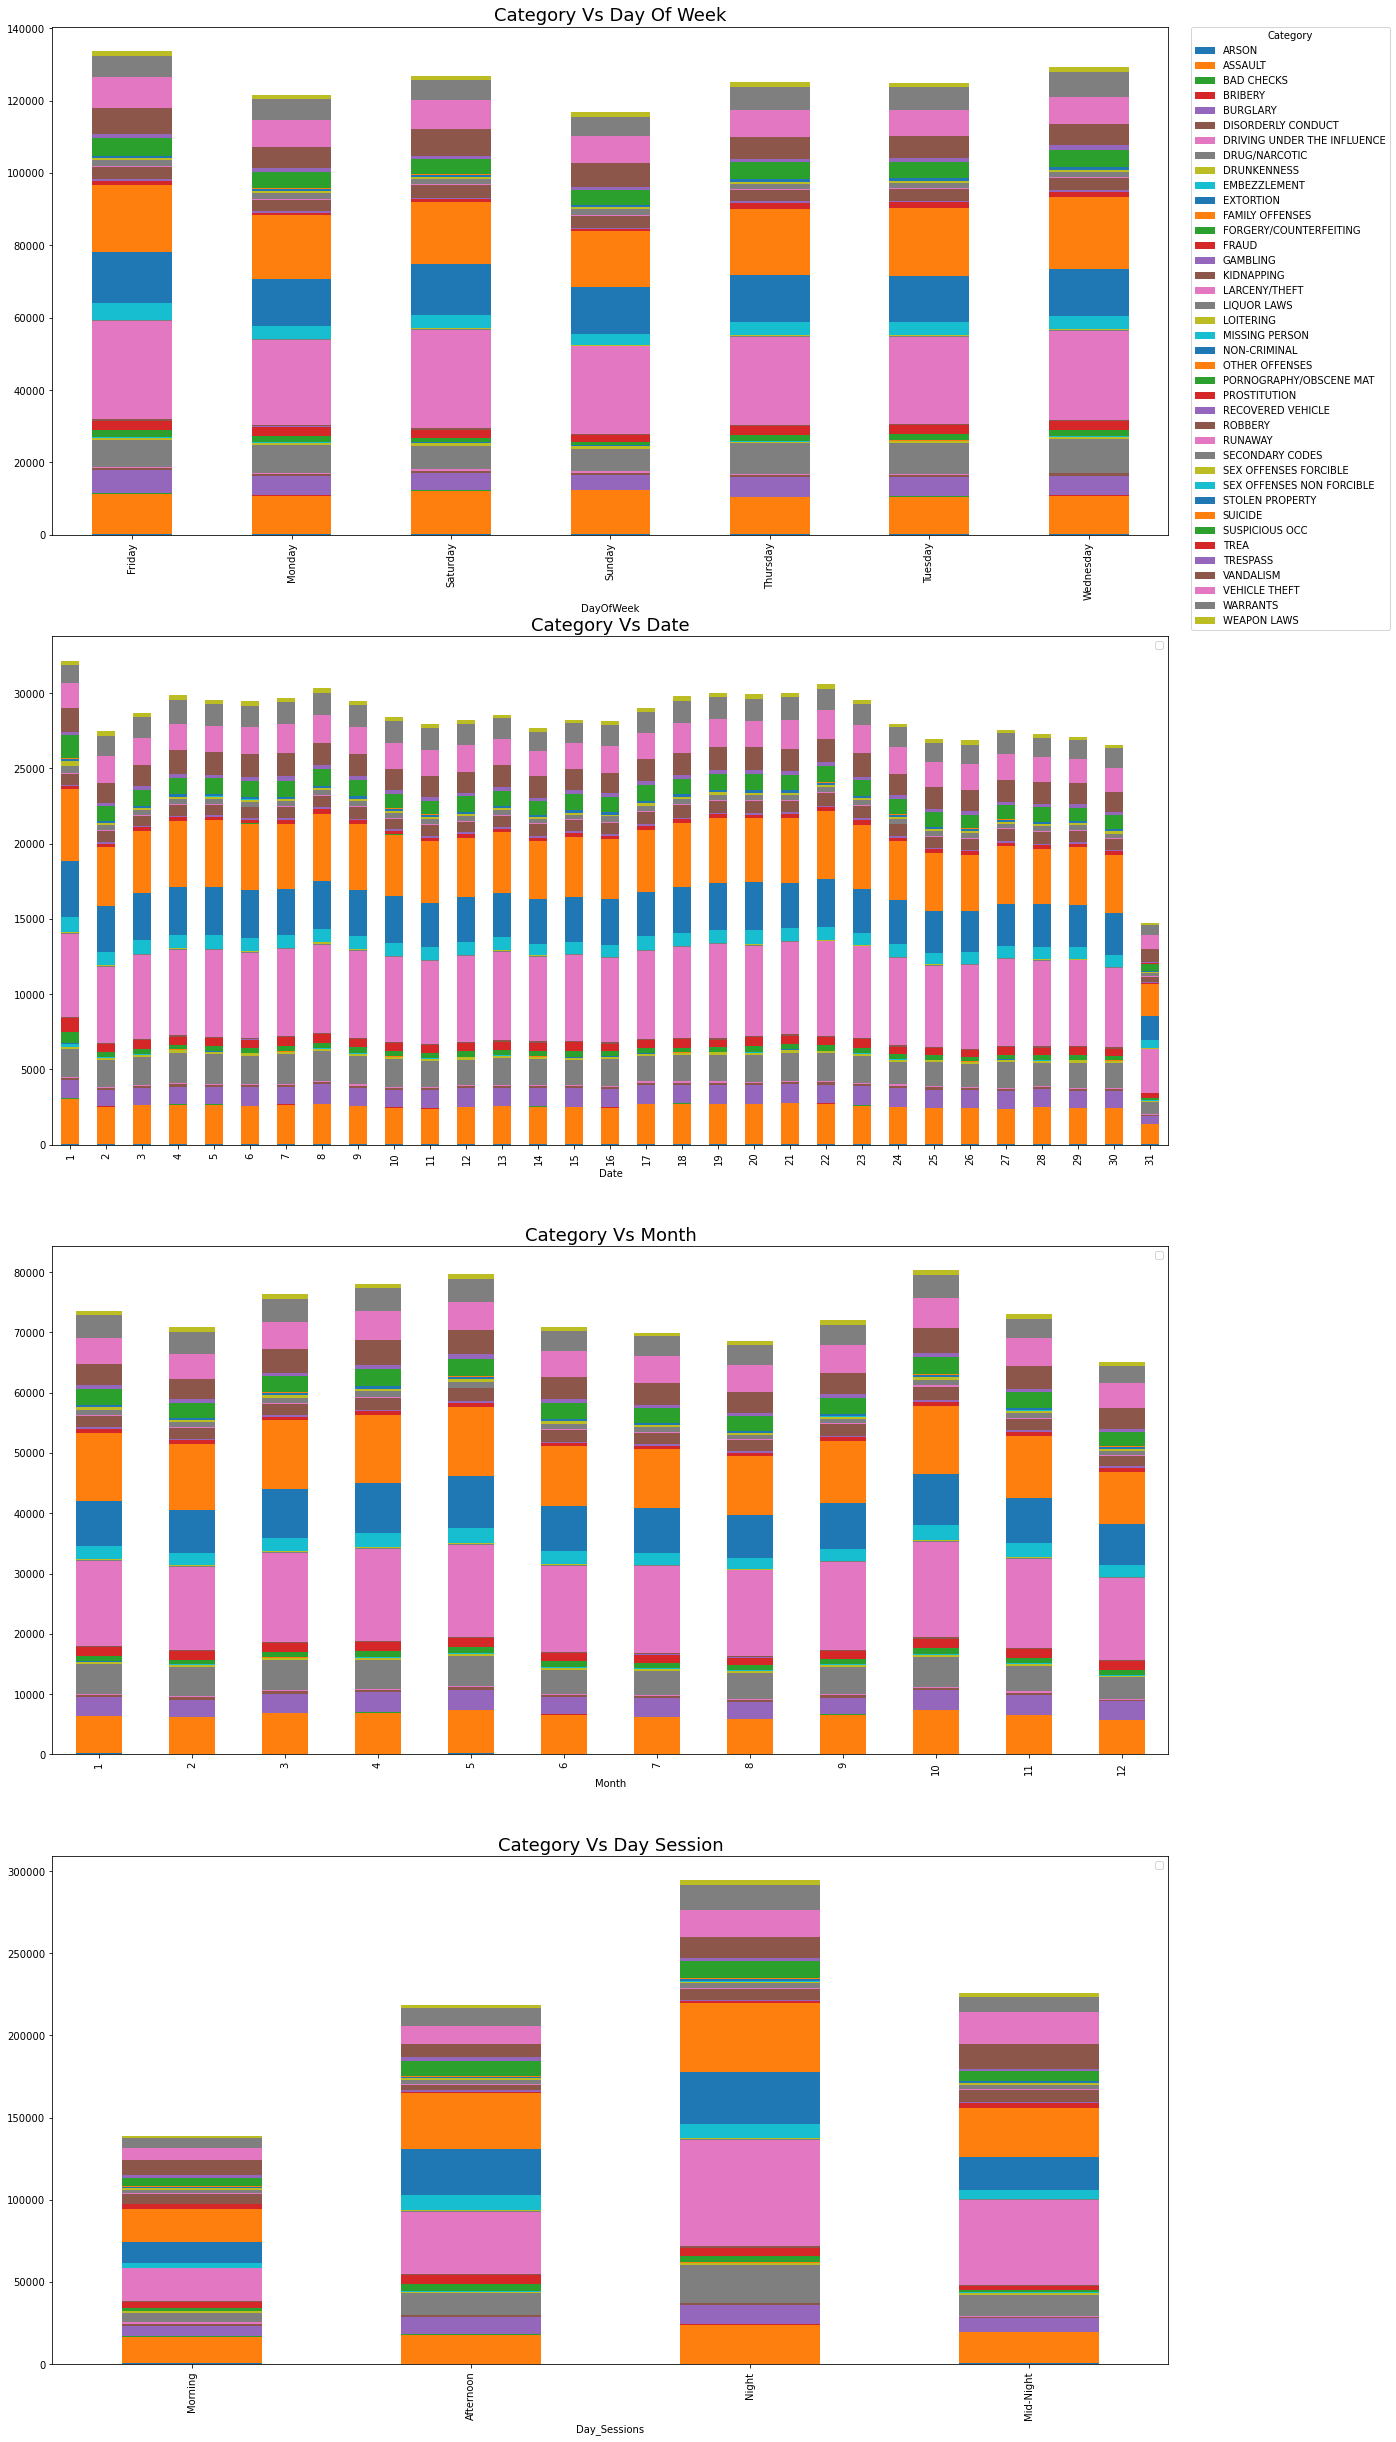

In [101]:
fig, ax= plt.subplots(nrows=4, ncols=1)
fig.set_size_inches(20, 43)
tmp=pd.crosstab(train.DayOfWeek, train.Category).plot.bar(stacked=True, ax=ax[0])
ax[0].legend(title='Category', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax[0].set_title("Category Vs Day Of Week", size=18)

tmp=pd.crosstab(train.Date, train.Category).plot.bar(stacked=True, ax=ax[1])
ax[1].legend([])
ax[1].set_title("Category Vs Date", size=18)

tmp=pd.crosstab(train.Month, train.Category).plot.bar(stacked=True, ax=ax[2])
ax[2].legend([])
ax[2].set_title("Category Vs Month", size=18)

tmp=pd.crosstab(train.Day_Sessions, train.Category).plot.bar(stacked=True, ax=ax[3])
ax[3].legend([])
ax[3].set_title("Category Vs Day Session", size=18)
plt.show()


### Crime data based on District and Street Numbers

In [102]:
# unique street values
train.Street.unique()

array([0, '1500', '100', '0', '600', '200', '1600', '300', '2000', '500',
       '1300', '400', '1400', '700', '800', '900', '1900', '4600', '3100',
       '1000', '1200', '2300', '1100', '2100', '2200', '2400', '1700',
       '3600', '1800', '5300', '5700', '3700', '3200', '3000', '2600',
       '4100', '2700', '2500', '3300', '4900', '5600', '4000', '4700',
       '3500', '3900', '3400', '2900', '6100', '2800', '3800', '6300',
       '4400', '5000', '5200', '4500', '4300', '6000', '4200', '5100',
       '4800', '6500', '5900', '5800', '5400', '5500', '6200', '6600',
       '8000', '6400', '7000', '6800', '7900', '7200', '7400', '7100',
       '7600', '7700', '6900', '6700', '7300', '7500', '8100', '7800',
       '8200', '8300'], dtype=object)

##### Removing data for visualizing where street value is not present.

In [103]:
street_data = train[train.Street!=0]

Text(0.5, 1.0, 'Category Vs Street')

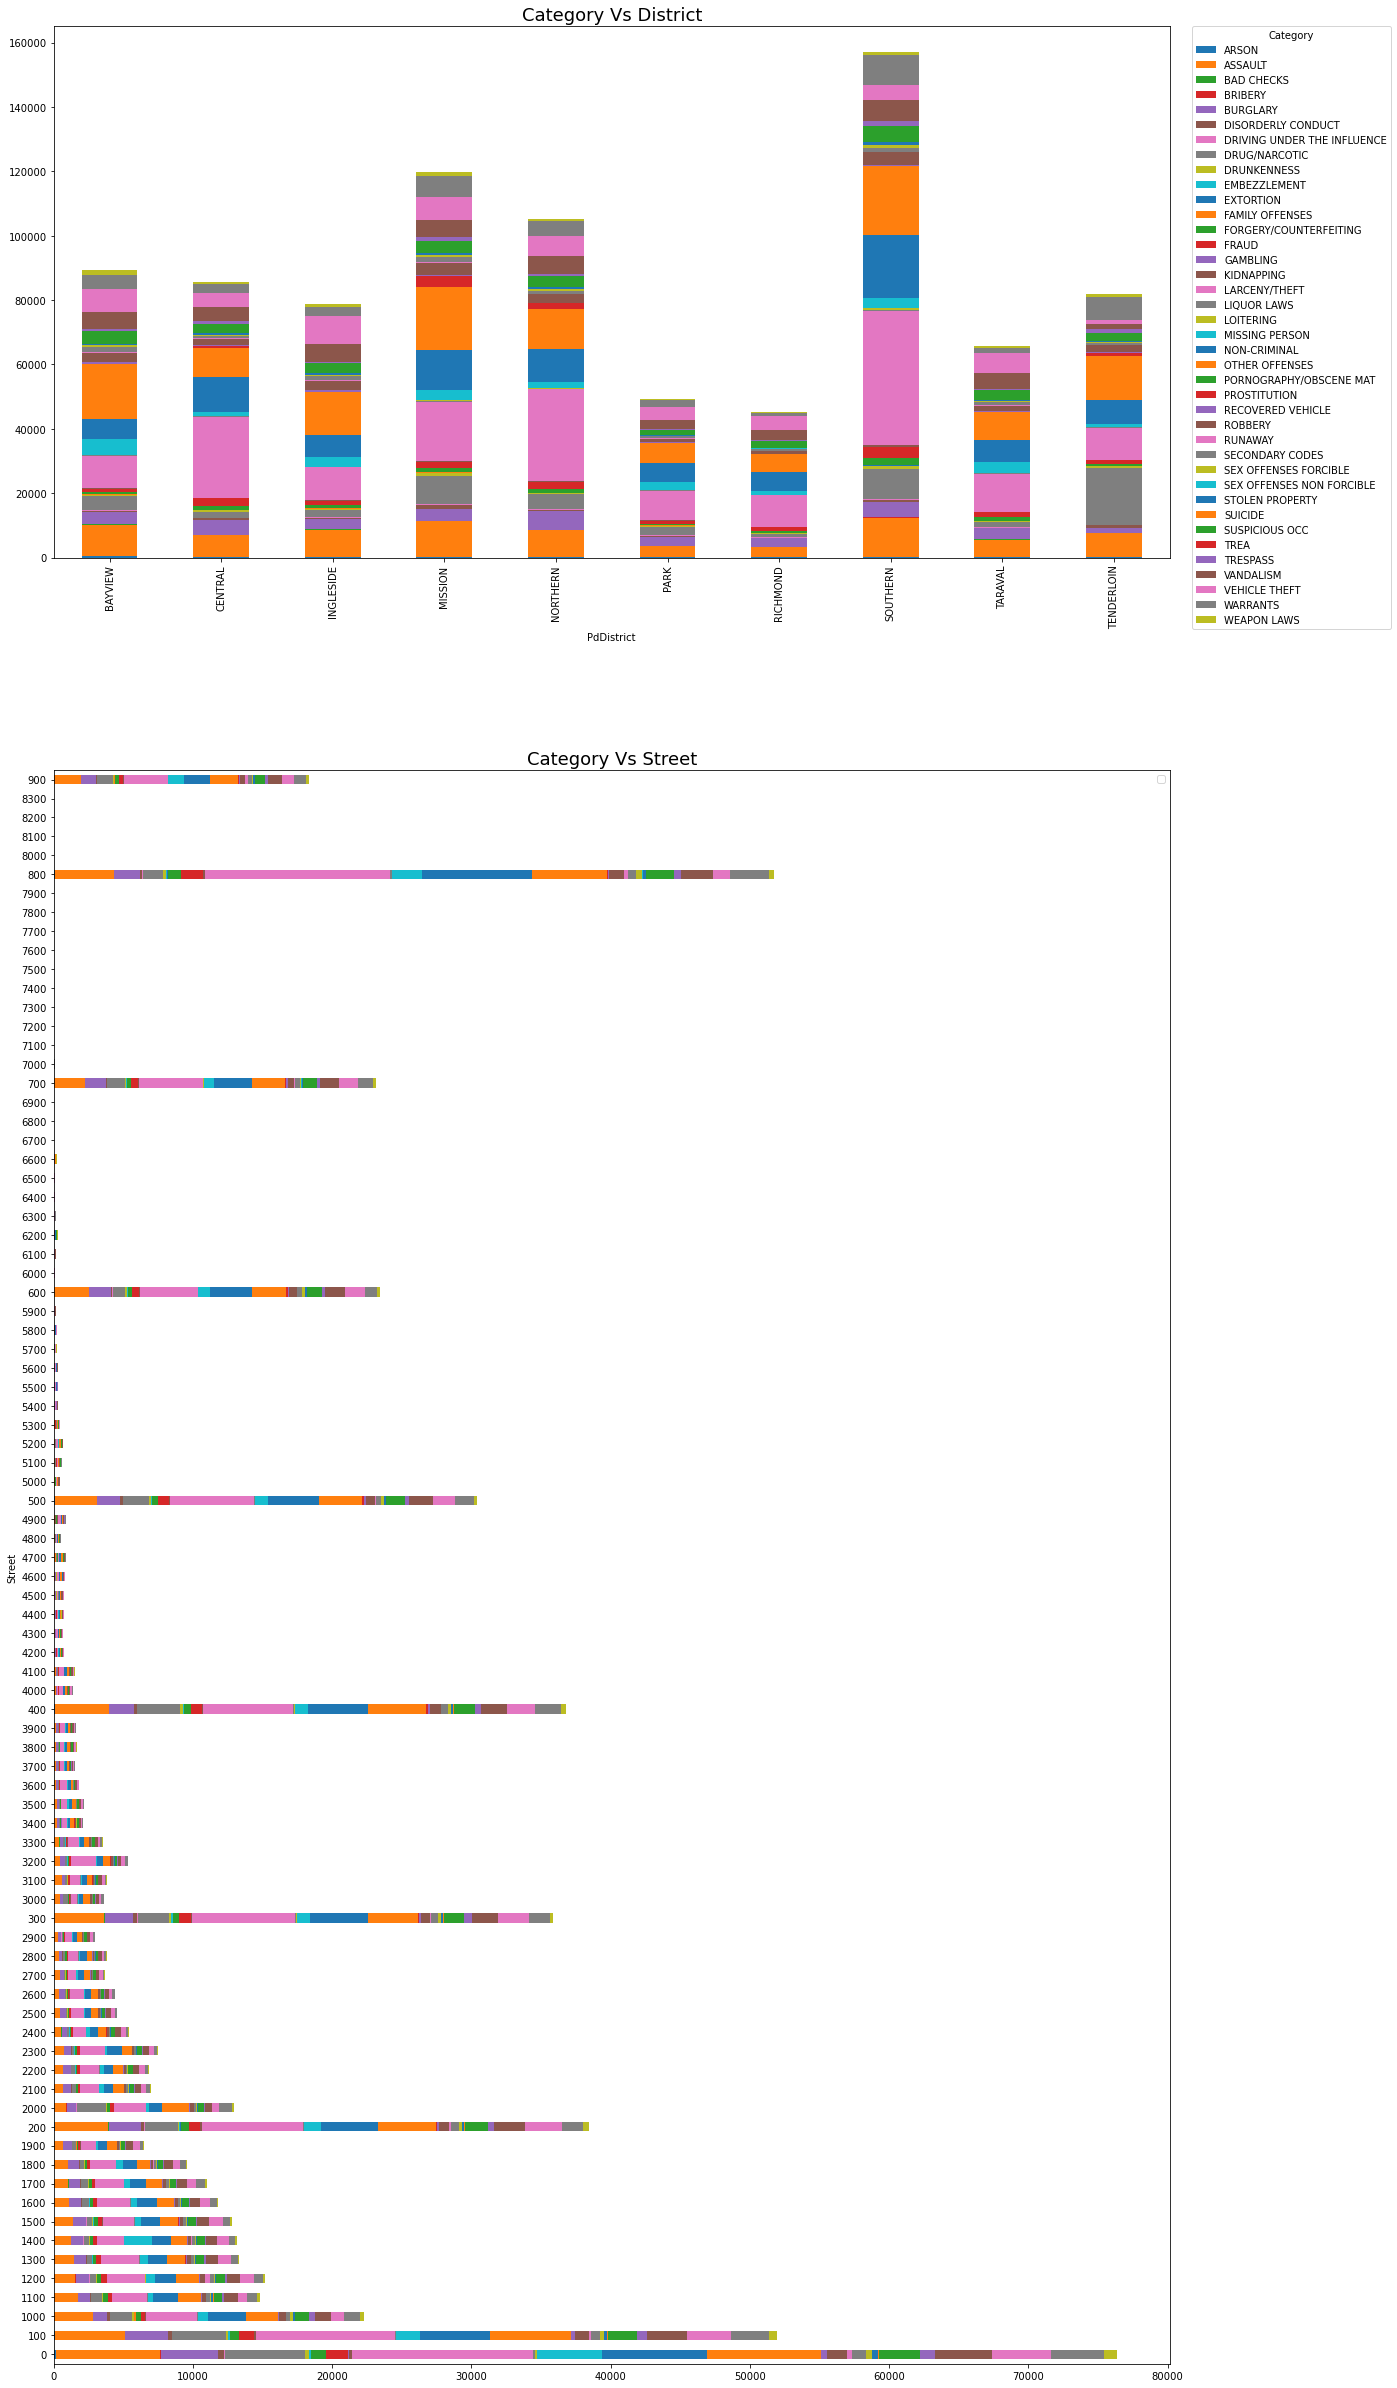

In [104]:
fig, ax= plt.subplots(nrows=2, ncols=1, gridspec_kw = {'height_ratios':[1, 3]})
fig.set_size_inches(20, 43)
tmp=pd.crosstab(train.PdDistrict, train.Category).plot.bar(stacked=True, ax=ax[0])
ax[0].legend(title='Category', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax[0].set_title("Category Vs District", size=18)
tmp=pd.crosstab(street_data.Street, street_data.Category).plot.barh(stacked=True, ax=ax[1])
ax[1].legend([])
ax[1].set_title("Category Vs Street", size=18)

seasons_in_sf = {
    'January':'Winter',
    'February':'Winter',
    'March':'Spring',
    'April':'Spring',
    'May':'Spring',
    'June':'Summer',
    'July':'Summer',
    'August':'Summer',
    'September':'Fall',
    'October':'Fall',
    'November':'Fall',
    'December':'Winter'
}

### Making Data ready to be passed to models for training and testing

In [105]:
# months: number to actual name
number_to_monthNames = {
    1:'January',
    2:'February',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'August',
    9:'September',
    10:'October',
    11:'November',
    12:'December'
}

In [106]:
# Dictionary for seasons
seasons_in_sf = {
    'January':'Winter',
    'February':'Winter',
    'March':'Spring',
    'April':'Spring',
    'May':'Spring',
    'June':'Summer',
    'July':'Summer',
    'August':'Summer',
    'September':'Fall',
    'October':'Fall',
    'November':'Fall',
    'December':'Winter'
}

In [107]:
crime_category = {
    'LARCENY/THEFT' : 'Theft',
    'VEHICLE THEFT': 'Theft',
    'BURGLARY': 'Theft',
    'SEX OFFENSES FORCIBLE':'Sexual offences',
    'SEX OFFENSES NON FORCIBLE':'Sexual offences',
    'PORNOGRAPHY/OBSCENE MAT':'Sexual offences',
    'PROSTITUTION': 'Sexual offences',
    'DRUNKENNESS': 'Public order',
    'SUSPICIOUS OCC': 'Public order',
    'BRIBERY': 'Public order',
    'DRIVING UNDER THE INFLUENCE': 'Public order',
    'RECOVERED VEHICLE': 'Public order',
    'BAD CHECKS': 'Public order',
    'LOITERING':'Public order',
    'DISORDERLY CONDUCT':'Public order',
    'LIQUOR LAWS': 'Public order',
    'TRESPASS': 'Public order',
    'ROBBERY': 'Assault',
    'KIDNAPPING': 'Assault',
    'ASSAULT': 'Assault',
    'WEAPON LAWS':'Public order',
    'DRUG/NARCOTIC': 'Drug offences',
    'TREA': 'Property crime',
    'EMBEZZLEMENT': 'Property crime',
    'STOLEN PROPERTY':'Property crime',
    'VANDALISM': 'Property crime',
    'ARSON': 'Property crime',
    'FRAUD': 'White-collor crime',
    'FORGERY/COUNTERFEITING': 'White-collor crime',
    'SECONDARY CODES': 'White-collor crime',
    'GAMBLING': 'Victimless-crime',
    'RUNAWAY': 'Victimless-crime',
    'SUICIDE': 'Suicide',
    'FAMILY OFFENSES': 'Suicide',
    'MISSING PERSON': 'Suicide',
    'EXTORTION' :'Suicide',
    'WARRANTS': 'Other',
    'OTHER OFFENSES': 'Other',
    'NON-CRIMINAL':'Other'
}

In [108]:
train_data = pd.read_csv('train.csv')
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [109]:
date_time = train_data['Dates'].str.split(' ', n=1, expand= True)

In [110]:
# Extracting the date and time
train_data['Date'] = date_time[0]
train_data['Time'] = date_time[1]

In [111]:
# Coverting timestamp to hour
time = pd.DatetimeIndex(train_data['Time'])
train_data['Hour'] = time.hour

In [112]:
# Generating Day Session data using Hour value
train_data = train_data.assign(Day_Sessions=pd.cut(train_data['Hour'],[-1,6,12,17,20,25],labels=['Post-Midnight','Morning','Afternoon','Evening','Night']))

In [113]:
# Extacting the exact date
date = pd.DatetimeIndex(train_data['Date'])

In [114]:
# Obtaining the respective year, month and day
train_data['Year'] = date.year
train_data['Month'] = date.month
train_data['Day']= date.day

In [115]:
# Mapping the months to respective seasons
train_data['Season'] = train_data['Month'].map(number_to_monthNames)
train_data['Season'] = train_data['Season'].map(seasons_in_sf)

In [116]:
# Dropping one outlier
train_data = train_data[train_data.Y != 90]

In [117]:
train_data.isnull().sum(axis = 0)

Dates           0
Category        0
Descript        0
DayOfWeek       0
PdDistrict      0
Resolution      0
Address         0
X               0
Y               0
Date            0
Time            0
Hour            0
Day_Sessions    0
Year            0
Month           0
Day             0
Season          0
dtype: int64

In [118]:
train_data.shape

(877982, 17)

In [119]:
train_data['Crime_Category'] = train_data['Category'].map(crime_category)

## Encoding Categorical Values

- Encoding categorical values supplant models to work well for categorical values

In [120]:
# Encoding District Category
pd_dist = preprocessing.LabelEncoder()
pd_dist.fit(train_data["PdDistrict"])
train_data['PdDistrict_LabelEncoded'] = pd_dist.transform(train_data["PdDistrict"])

In [121]:
# Encoding Crime Category
crime_category = preprocessing.LabelEncoder()
crime_category.fit(train_data["Category"])
train_data['Category_LabelEncoded'] = crime_category.transform(train_data["Category"])
crime_category.classes_

array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'], dtype=object)

In [122]:
# Encoding Sessions 
day_session = preprocessing.LabelEncoder()
day_session.fit(train_data.Day_Sessions)
train_data['Session_LabelEncoded'] = day_session.transform(train_data.Day_Sessions)

In [123]:
# Encoding Crime categories codes for 10 labels
crimeCategory_encode = preprocessing.LabelEncoder()
crimeCategory_encode.fit(train_data['Crime_Category'])
train_data['Crime_Category_LabelEncoded'] = crimeCategory_encode.transform(train_data['Crime_Category'])

In [124]:
# Encoding Seasons
season_encode = preprocessing.LabelEncoder()
season_encode.fit(train_data['Season'])
train_data['season_LabelEncoded'] = season_encode.transform(train_data['Season'])
# le_name_mapping = dict(zip(le.classes_, season_encode.transform(le.classes_)))

In [125]:
train_data.shape

(877982, 23)

In [126]:
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,...,Year,Month,Day,Season,Crime_Category,PdDistrict_LabelEncoded,Category_LabelEncoded,Session_LabelEncoded,Crime_Category_LabelEncoded,season_LabelEncoded
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,...,2015,5,13,Spring,Other,4,37,3,2,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,...,2015,5,13,Spring,Other,4,21,3,2,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13,...,2015,5,13,Spring,Other,4,21,3,2,1
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13,...,2015,5,13,Spring,Theft,4,16,3,7,1
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13,...,2015,5,13,Spring,Theft,5,16,3,7,1


### Training the Supervided models using features: PdDistrict, Session, Season as input features and Crime category as a label to be predicted

Following are models used for carrying out this experiment
- K-Nearest Neighbor
- Decision Tree Classifier
- Random Forest Classifier

### Experiment 1 - [10 labels]
### K Nearest Neighbors Classifier

In [127]:
# partition dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(train_data[['PdDistrict_LabelEncoded', 'Session_LabelEncoded', 'season_LabelEncoded']],train_data['Category_LabelEncoded'], test_size=0.30, random_state = 0)

In [128]:
# standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)

In [129]:
# CLASSIFIER: k-Nearest Neighbors
# initialize k-nearest neighbors classifier = 25
classifier = KNeighborsClassifier(n_neighbors = 25) 
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [130]:
# predict class labels using k-nearest neighbors classifier
y_pred = classifier.predict(x_test)

In [131]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[   0   51    0 ...    4    4    0]
 [   0 1826    0 ...  569  196    0]
 [   0    9    0 ...    2    2    0]
 ...
 [   0  890    0 ...  874   97    0]
 [   0  820    0 ...  199  213    0]
 [   0  182    0 ...   76   16    0]]


In [132]:
# compute evaluation metrics for k=25 and labels = 39
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.19527705537310883
0.8047229446268912
0.14731143375846306
0.22186898794785745
0.15747609841859764


In [133]:
# CLASSIFIER: k-Nearest Neighbors
# initialize k-nearest neighbors classifier = 40
classifier = KNeighborsClassifier(n_neighbors = 40) 
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [134]:
# predict class labels using k-nearest neighbors classifier
y_pred = classifier.predict(x_test)

In [135]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[   0   59    0 ...    3    0    0]
 [   0 1548    0 ...  382    0    0]
 [   0   10    0 ...    1    0    0]
 ...
 [   0  936    0 ...  633    0    0]
 [   0  664    0 ...  143    0    0]
 [   0  197    0 ...   54    0    0]]


In [136]:
# compute evaluation metrics for k=40 and labels = 39
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.2087511152451641
0.7912488847548359
0.16935814341672029
0.27117774709015585
0.1821469225701957


### Decision Tree Classifier

In [137]:
# Using Decision Tree Classifier Algorithm to make model for predicting.
model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0)
scores = cross_val_score(model, x_train, y_train, cv=4, scoring='accuracy')
print(scores.mean())

0.22378280119887534


In [138]:
# build decision tree
model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0)
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [139]:
# predict class labels using decision tree
y_pred = model.predict(x_test)

In [140]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[   0    0    0 ...   20    0    0]
 [   0    0    0 ...  628    0    0]
 [   0    0    0 ...    1    0    0]
 ...
 [   0    0    0 ... 1118    0    0]
 [   0    0    0 ...  173    0    0]
 [   0    0    0 ...   89    0    0]]


In [141]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.22344767364604493
0.7765523263539551
0.20461538374802796
0.3914506720939668
0.23039368855016196


### Random Forest Classifier

In [142]:
# CLASSIFIER: Random forest
# build random forest
RandomForestmodel = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 0)
RandomForestmodel.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [143]:
# predict class labels using decision tree
y_pred = RandomForestmodel.predict(x_test)

In [144]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[   0    0    0 ...   20    0    0]
 [   0    0    0 ...  628    0    0]
 [   0    0    0 ...    1    0    0]
 ...
 [   0    0    0 ... 1118    0    0]
 [   0    0    0 ...  173    0    0]
 [   0    0    0 ...   89    0    0]]


In [145]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.22344767364604493
0.7765523263539551
0.20461538374802796
0.3914506720939668
0.23039368855016196


### Experiment 2 - [10 labels]

In [146]:
# partition dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(train_data[['PdDistrict_LabelEncoded', 'Session_LabelEncoded', 'season_LabelEncoded']],train_data['Crime_Category_LabelEncoded'], test_size=0.30, random_state = 0)

In [147]:
# standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)

In [148]:
# CLASSIFIER: k-Nearest Neighbors
# initialize k-nearest neighbors classifier = 10
classifier = KNeighborsClassifier(n_neighbors = 10) 
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [149]:
# predict class labels using k-nearest neighbors classifier
y_pred = classifier.predict(x_test)

In [150]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 2923  1188 15053   440   747     0     0 10239     0    70]
 [ 1115  1870  8510   100   283     0     0  4389     0    15]
 [ 5982  3592 39813  1079  1767     0     0 25950     0   170]
 [ 1342   330  7006   288   415     0     0  6133     0    73]
 [ 1776   814  9873   352   484     0     0  6341     0    60]
 [  469   213  1723    29    64     0     0  1071     0     4]
 [  700   192  4212   156   184     0     0  2778     0     9]
 [ 5388  1822 36343  1058  2032     0     0 32517     0   155]
 [   60     6   286    17    16     0     0   242     0     1]
 [  915   352  5715   239   213     0     0  3595     0    37]]


In [151]:
# compute evaluation metrics for k=10 and labels = 10
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.29587501661003435
0.7041249833899657
0.24950129899400691
0.31053183138550305
0.26734201778596384


In [152]:
# CLASSIFIER: k-Nearest Neighbors
# initialize k-nearest neighbors classifier = 25
classifier = KNeighborsClassifier(n_neighbors = 25) 
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [153]:
# predict class labels using k-nearest neighbors classifier
y_pred = classifier.predict(x_test)

In [154]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 1454   760 15997     0    57     0     0 12392     0     0]
 [  584  1768  9354     0    29     0     0  4547     0     0]
 [ 2603  2414 41902     0   251     0     0 31183     0     0]
 [  639   137  7160     0    45     0     0  7606     0     0]
 [  796   475 10655     0    62     0     0  7712     0     0]
 [  200    72  1865     0     3     0     0  1433     0     0]
 [  230    77  4484     0    30     0     0  3410     0     0]
 [ 2224  1221 34161     0   325     0     0 41384     0     0]
 [   10     2   302     0     4     0     0   310     0     0]
 [  380   232  5873     0    50     0     0  4531     0     0]]


In [155]:
# compute evaluation metrics for k=25 and labels = 10
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.32866986844852786
0.6713301315514721
0.28496518724125675
0.3859391021354376
0.3117935964027765


### Decision Tree Classifier

In [156]:
# Using Decision Tree Classifier Algorithm to make model for predicting.
model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0)
scores = cross_val_score(model, x_train, y_train, cv=4, scoring='accuracy')
print(scores.mean())

0.34961201507466144


In [157]:
# build decision tree
model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0)
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [158]:
# predict class labels using decision tree
y_pred = model.predict(x_test)

In [159]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[    0     0 16583     0     0     0     0 14077     0     0]
 [    0     0 10976     0     0     0     0  5306     0     0]
 [    0     0 43067     0     0     0     0 35286     0     0]
 [    0     0  7029     0     0     0     0  8558     0     0]
 [    0     0 10837     0     0     0     0  8863     0     0]
 [    0     0  1868     0     0     0     0  1705     0     0]
 [    0     0  4659     0     0     0     0  3572     0     0]
 [    0     0 30480     0     0     0     0 48835     0     0]
 [    0     0   319     0     0     0     0   309     0     0]
 [    0     0  5913     0     0     0     0  5153     0     0]]


Text(0.5, 1.0, 'Confusion matrix')

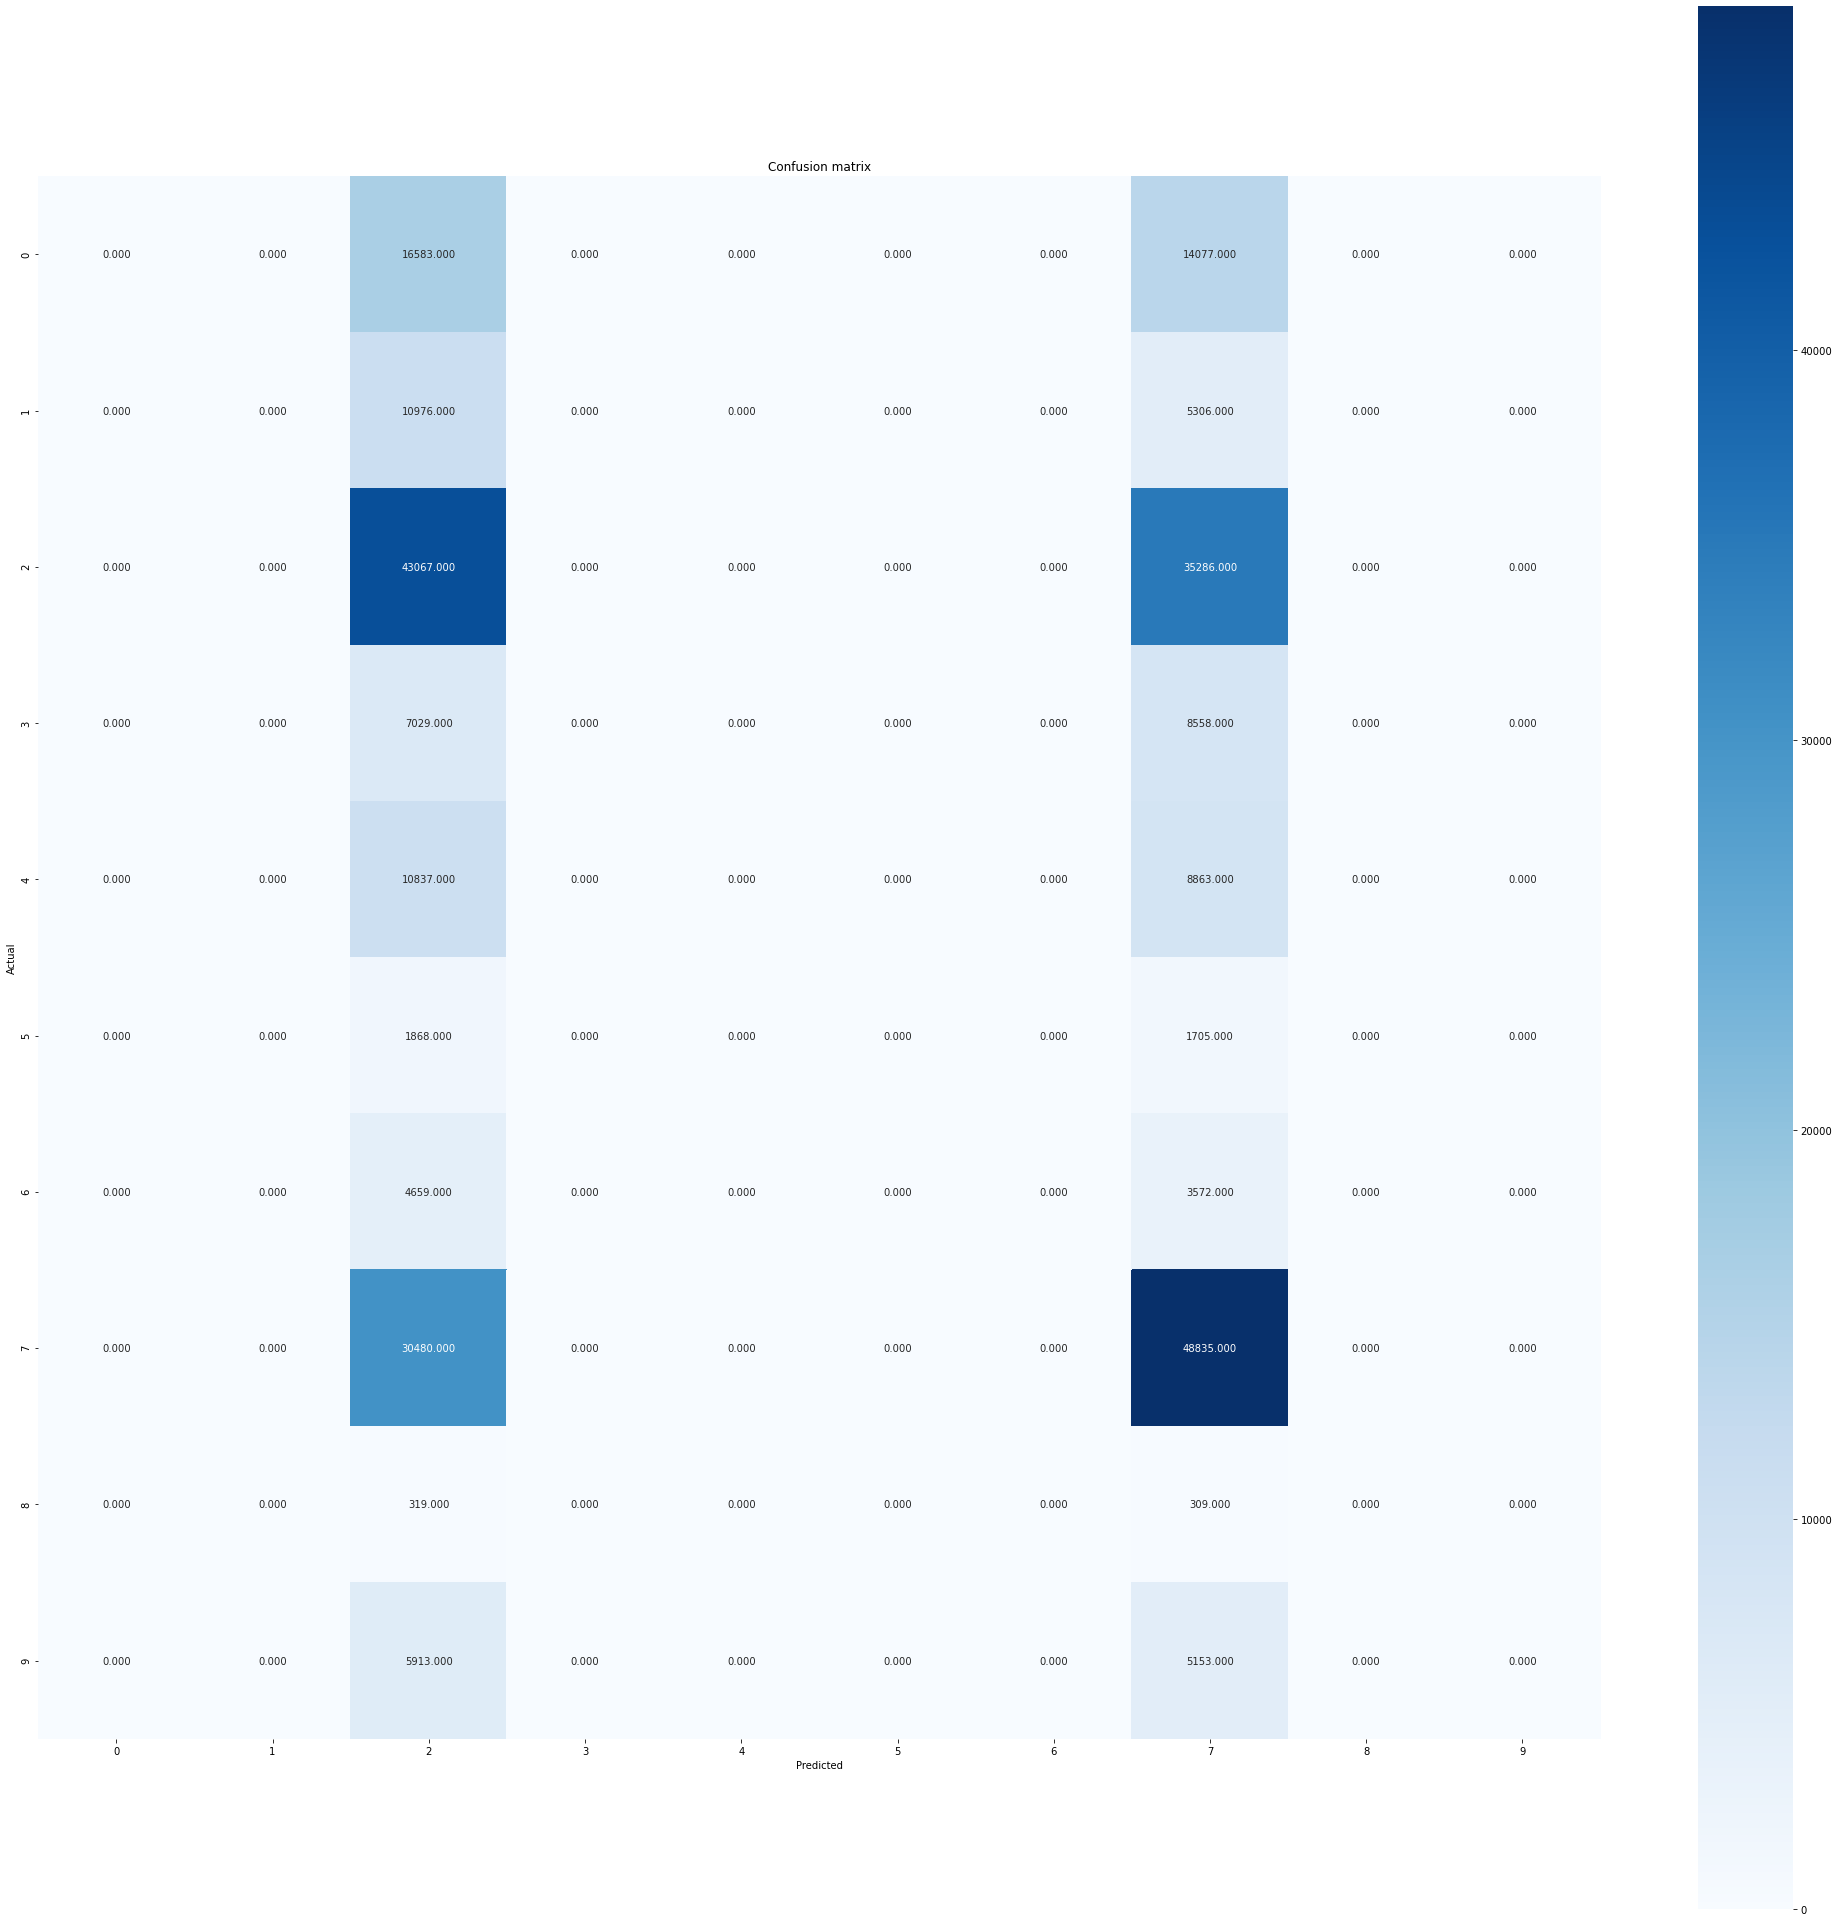

In [160]:
# plot confusion matrix
plt.subplots(figsize=(35,35))
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [161]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.3489132291805084
0.6510867708194916
0.349052976831231
0.5828830200167441
0.4366289898399862


## Random Forest

In [162]:
# CLASSIFIER: Random forest
# build random forest
RandomForestmodel = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 0)
RandomForestmodel.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [163]:
# predict class labels using decision tree
y_pred = RandomForestmodel.predict(x_test)

In [164]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[    0     0 16409     0     0     0     0 14251     0     0]
 [    0     0 10914     0     0     0     0  5368     0     0]
 [    0     0 42596     0     0     0     0 35757     0     0]
 [    0     0  6855     0     0     0     0  8732     0     0]
 [    0     0 10709     0     0     0     0  8991     0     0]
 [    0     0  1850     0     0     0     0  1723     0     0]
 [    0     0  4600     0     0     0     0  3631     0     0]
 [    0     0 30091     0     0     0     0 49224     0     0]
 [    0     0   318     0     0     0     0   310     0     0]
 [    0     0  5851     0     0     0     0  5215     0     0]]


Text(0.5, 1.0, 'Confusion matrix')

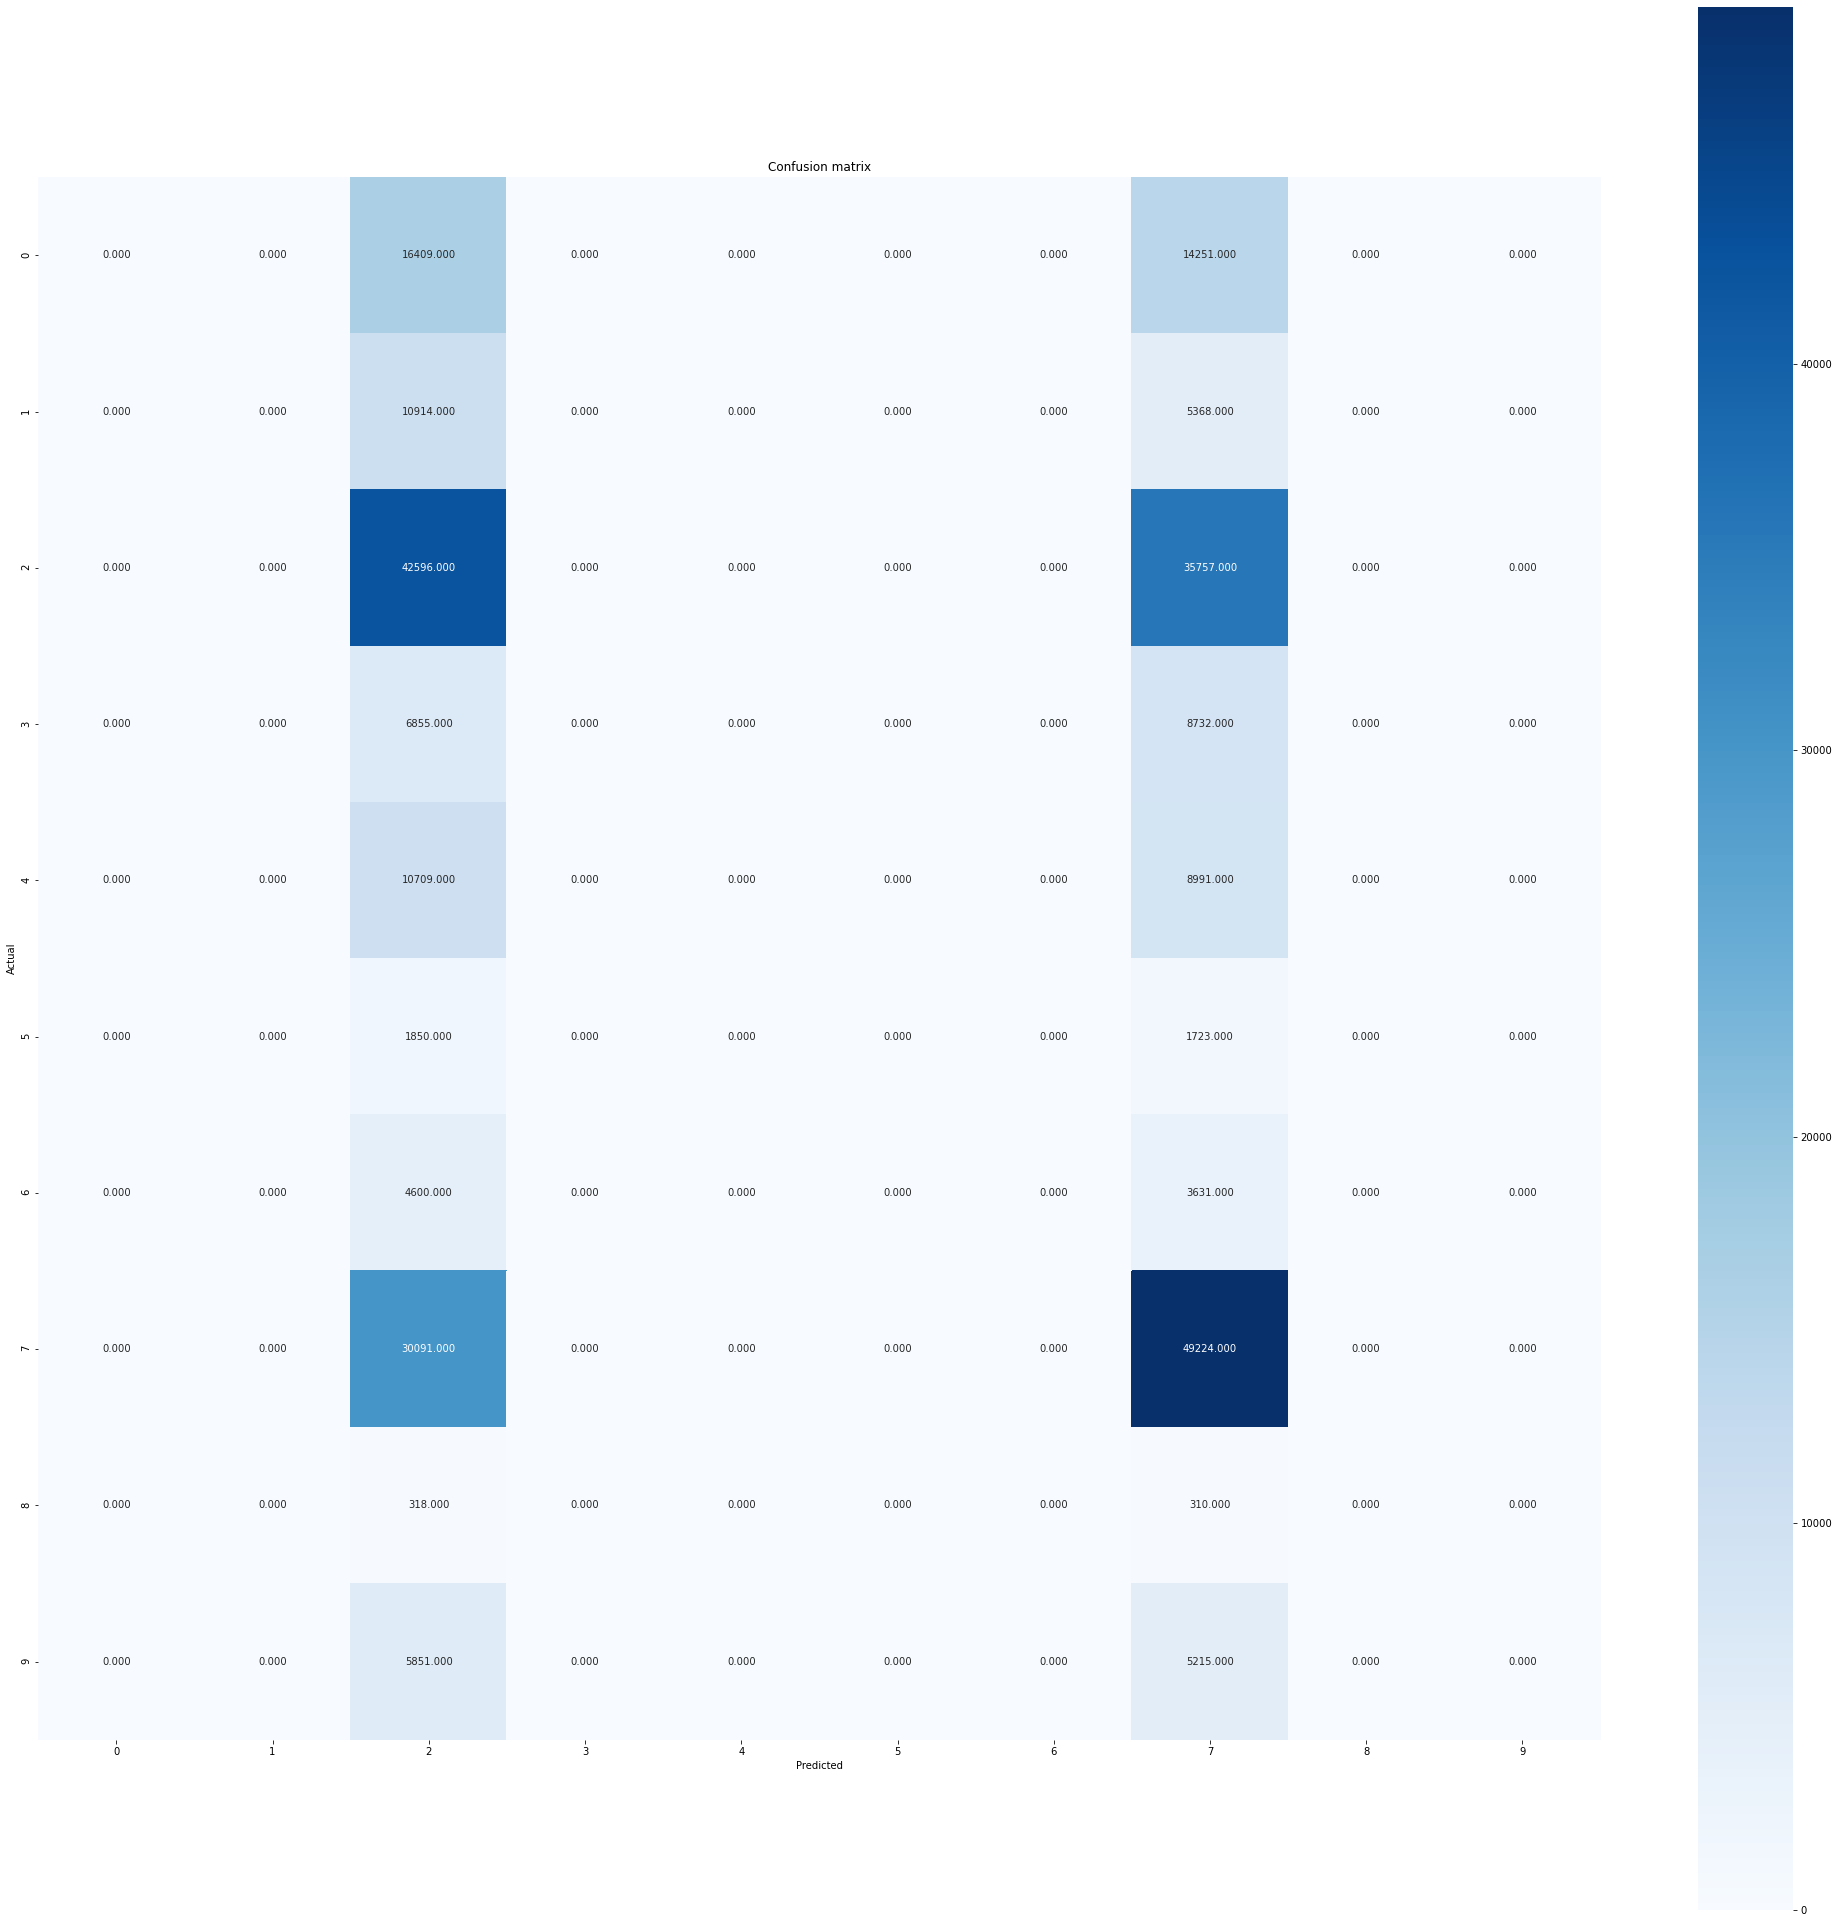

In [165]:
# plot confusion matrix
plt.subplots(figsize=(35,35))
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [166]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.3486019096793789
0.6513980903206211
0.3484891577771065
0.5823629398482888
0.43604312767856174


## Clustering

In [167]:
# factorize class labels
factor = pd.factorize(train_data['Category'])
print(factor[0])
train_data['Category'] = factor[0]

[ 0  1  1 ...  2  4 12]


In [168]:
# Selecting the features for Clustering
X = train_data[['Day','Year','Session_LabelEncoded']]
Y = train_data['Category']

In [169]:
sse = []
list_k = list(range(5, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

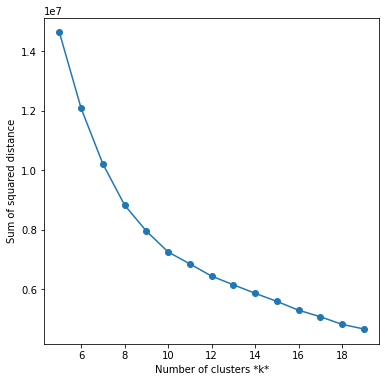

In [170]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [171]:
# CLUSTERING: K-Means clustering (random initialization, single iteration)
clustering = KMeans(n_clusters = 39, init = 'random', n_init = 1, random_state = 2).fit(X)

In [172]:
# show centroids
clustering.cluster_centers_

array([[2.65325031e+01, 2.00415314e+03, 1.80207335e+00],
       [2.89665764e+01, 2.00731293e+03, 5.54548664e-01],
       [1.11706705e+01, 2.00688297e+03, 2.65590931e+00],
       [8.32918599e+00, 2.00920761e+03, 8.49410036e-01],
       [1.78003428e+01, 2.01365913e+03, 9.12660191e-01],
       [1.55675533e+01, 2.01102289e+03, 2.56106921e+00],
       [5.58752301e+00, 2.01104369e+03, 1.75070567e+00],
       [5.44714350e+00, 2.01380627e+03, 1.77241715e+00],
       [2.49990735e+01, 2.00699307e+03, 1.83463490e+00],
       [1.36005891e+01, 2.01342924e+03, 1.60008416e+00],
       [9.27605592e+00, 2.01337577e+03, 1.57108514e+00],
       [2.61827432e+01, 2.01314642e+03, 1.15990028e+00],
       [1.07772046e+01, 2.01075926e+03, 3.27900478e+00],
       [2.75963859e+01, 2.01025041e+03, 7.95773354e-01],
       [2.90436098e+01, 2.00849495e+03, 3.13966007e+00],
       [2.28731997e+01, 2.00434829e+03, 1.70148478e+00],
       [2.14308926e+01, 2.00820671e+03, 1.70288455e+00],
       [2.03308311e+00, 2.00967

In [173]:
# show clusters
clusters = clustering.labels_
print(clusters)

[ 9  9  9 ... 33 33 33]


Text(0.5, 1.0, 'Confusion matrix')

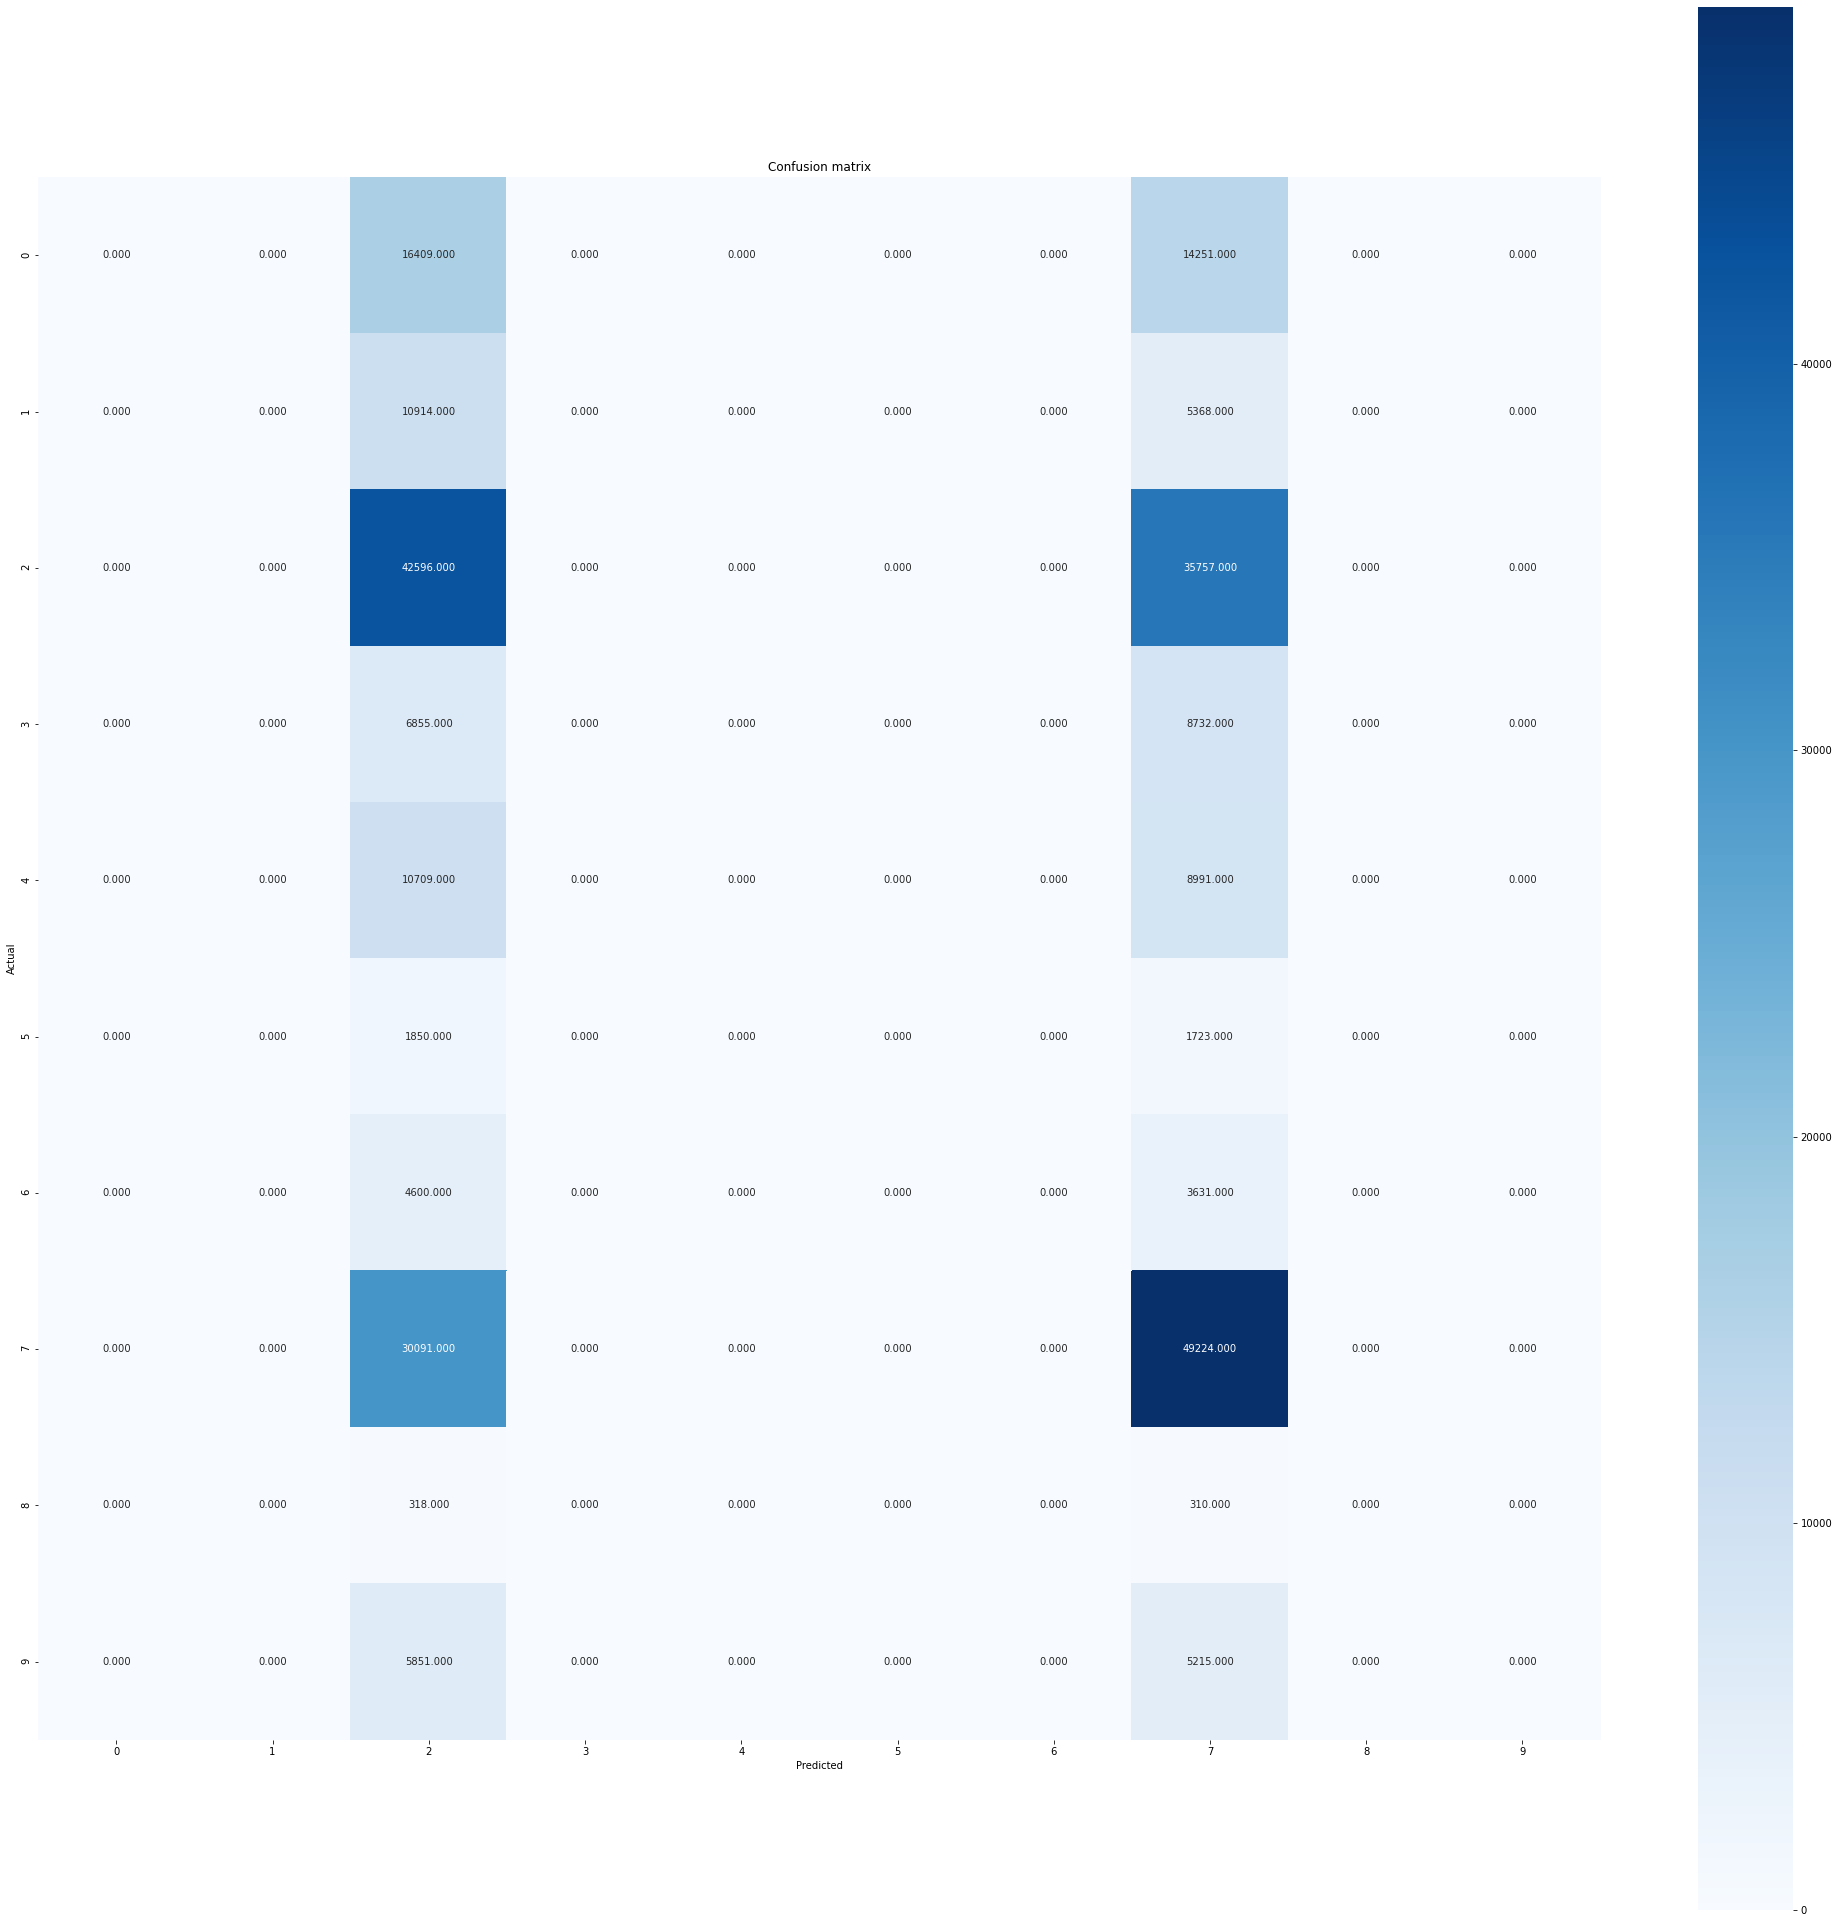

In [174]:
# plot contingency matrix
plt.subplots(figsize=(35,35))
cont_matrix = metrics.cluster.contingency_matrix(train_data['Category'], clusters)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [175]:
# compute normalized mutual information
print(metrics.normalized_mutual_info_score(train_data['Category'], clusters))

0.0063333552057298565


## Conclusion
We understand that accuracy values are not as it comes in general but from this dataset we can come to know that type of crime is less depedent on weather, season, session or district in which it is happening. Maybe, some other external factors like income, economic conditionf of state, etc plays vital role.

Also, from the experiments we learned that if we reduce number of labels we can attain good accuracy.